In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.preprocessing import LabelEncoder

### とりあえず2日目で学んだ内容で、学習に使うデータは変えずに、どのくらい精度などが変わるか見てみる

### 1. データの読み込み

In [9]:
df_origin = pd.read_csv("../ks-projects-201801.csv")

# データ表示
display(df_origin.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### 2. 学習に使うデータを作成

In [10]:
# 「成功」か「失敗」だけのレコードを抽出(成功か失敗かで完了してしまっているデータ)
df_success_or_failed = df_origin[(df_origin["state"] == "successful") | (df_origin["state"] == "failed")]

# カテゴリ変数の数値化
# 不要だと思われる「ID」と「name」カラムは削除する
df_success_or_failed = df_success_or_failed.drop("ID", axis = 1)
df_success_or_failed = df_success_or_failed.drop("name", axis = 1)

In [11]:
# LabelEncoderでカテゴリ変数を数値化
le = LabelEncoder()
# 「fit」と「transform」を分けることも出来る（fitで変換式を保存しておいて、fitの戻り値を使いまわすことができる）
# 数値化した列には「_class」を付加した列としてセットする
df_success_or_failed["category_class"] = le.fit_transform(df_success_or_failed["category"])
df_success_or_failed["main_category_class"] = le.fit_transform(df_success_or_failed["main_category"])
df_success_or_failed["currency_class"] = le.fit_transform(df_success_or_failed["currency"])
df_success_or_failed["state_class"] = le.fit_transform(df_success_or_failed["state"])
df_success_or_failed["country_class"] = le.fit_transform(df_success_or_failed["country"])

# カラムを並び変えたDataFrame作成
df_success_or_failed = df_success_or_failed.loc[:, ["category", "category_class",
                                                       "main_category", "main_category_class",
                                                        "state", "state_class",
                                                       "currency", "currency_class",
                                                       "deadline", "goal", "launched", "pledged",
                                                       "backers",
                                                       "country", "country_class",
                                                       "usd pledged", "usd_pledged_real", "usd_goal_real"]]
# 見やすいようにソートする
df_success_or_failed = df_success_or_failed.sort_values(by=["category_class", "main_category_class", "state_class"], 
                                                        ascending=[True, True, False])

In [12]:
# 事前にわからない情報を削除
for col in ["pledged", "backers", "usd pledged", "usd_pledged_real", "goal"]:
    df_success_or_failed = df_success_or_failed.drop(col, axis = 1)

# クラウドファンディング期間という新しい説明変数を作成
launched_time = pd.to_datetime(df_success_or_failed["launched"], format = "%Y-%m-%d %H:%M:%S")
deadline_time = pd.to_datetime(df_success_or_failed["deadline"], format = "%Y-%m-%d %H:%M:%S")
df_success_or_failed["term_days"] = (deadline_time - launched_time).dt.days

In [13]:
# カテゴリ変数をOne-hotベクトル化
category_class_dummy = pd.get_dummies(df_success_or_failed["category_class"], prefix="category")
main_category_class_dummy = pd.get_dummies(df_success_or_failed["main_category_class"], prefix="main_category")
currency_class_dummy = pd.get_dummies(df_success_or_failed["currency_class"], prefix="currency")
country_class_dummy = pd.get_dummies(df_success_or_failed["country_class"], prefix="country")

# 学習用データ
# One-hotベクトルにしたものから「main_category_class_dummy」と「currency_class_dummy」だけ使ってみる
df_for_learning = pd.concat([df_success_or_failed, main_category_class_dummy, currency_class_dummy], axis = 1)

# 不要なカラム削除
for col in ["category", "main_category", "state", "currency", "deadline", 
            "launched", "country", "category_class", "main_category_class", "currency_class", "country_class"]:
    df_for_learning = df_for_learning.drop(col, axis = 1)
    
df_for_learning.head()

,state_class,usd_goal_real,term_days,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,...,currency_4,currency_5,currency_6,currency_7,currency_8,currency_9,currency_10,currency_11,currency_12,currency_13
1000,1,25000.00,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1084,1,33659.83,29,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5028,1,47901.90,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8868,1,19403.91,28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10888,1,30000.00,33,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### データを学習用とテスト用に分ける

In [73]:
# 目的変数を除いたデータ
X = df_for_learning.iloc[:, 1:len(df_for_learning.columns)].values
# 目的変数
Y = df_for_learning["state_class"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1234)

#### データ標準化

In [74]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

# usd_goal_real
X_train[:, 0] = stdsc.fit_transform(X_train[:, 0].reshape(-1, 1)).reshape(-1)
X_test[:, 0]  = stdsc.transform(X_test[:, 0].reshape(-1, 1)).reshape(-1)

# term_days
X_train[:, 1] = stdsc.fit_transform(X_train[:, 1].reshape(-1, 1)).reshape(-1)
X_test[:, 1]  = stdsc.transform(X_test[:, 1].reshape(-1, 1)).reshape(-1)

In [16]:
from statistics import mean, median,variance,stdev

print("usd_goal_real: mean={:3f}, variance={:3f}".format(mean(X_test[:, 0]), variance(X_test[:, 0])))
print("term_days: mean={:3f}, variance={:3f}".format(mean(X_test[:, 1]), variance(X_test[:, 1])))

usd_goal_real: mean=0.003044, variance=0.996475
term_days: mean=0.008570, variance=1.019054


### 3. 学習

In [ ]:
%%time

# グリッドサーチだと丸１日以上かかっても学習が完了しなかったので中止
## グリッドサーチで最適なハイパーパラメータ探索してみる
#parameters = {"kernel":["linear", "rbf"], "C":[0.1, 1, 10]}
#model = SVC()
#clf = GridSearchCV(model, parameters, cv = 2,)
#clf.fit(X_train, Y_train)
#print(clf.best_params_, clf.best_score_)

In [ ]:
## 最適なハイパーパラメータで再学習
#clf_best = SVC(**clf.best_params_)
#clf_best.fit(X_train, Y_train)
#print("識別精度=",clf2.score(X_test, y_test))

In [11]:
%%time

# SVMの実行
C = 10
kernel = "rbf"
gamma = 1
clf = SVC(C = C, kernel = kernel, gamma = gamma)
clf.fit(X_train, Y_train)

CPU times: user 4h 20min 59s, sys: 408 ms, total: 4h 20min 59s
Wall time: 4h 20min 58s


In [12]:
# ラベルを予測
Y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(Y_test, Y_pred)
# Precision, Recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, Y_pred)

# 表示
print("対数尤度 = {:.3f}".format(- log_loss(Y_test, Y_pred)))
print("Accuracy(正答率) = {:.3f}%".format(accuracy * 100))
print("Precision(適合率) = {:.3f}%".format(precision[1] * 100))
print("Recall(再現率) = {:.3f}%".format(recall[1] * 100))
print("F1-score(F1値) = {:.3f}%".format(f1_score[1] * 100))

対数尤度 = -12.212
Accuracy(正答率) = 64.643%
Precision(適合率) = 60.161%
Recall(再現率) = 35.824%
F1-score(F1値) = 44.907%


In [14]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(Y_test, Y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=["正解 = failed", "正解 = successful"], 
                        columns=["予測 = failed", "予測 = successful"])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,33322,6330
正解 = successful,17124,9559


#### ハイパーパラメータの組み合わせを少なくしてグリッドサーチ

In [91]:
# SVMは学習にめちゃくちゃ時間がかかったので
# 学習データを更にランダム抽出する
import random

random.seed(1234)
# 抽出行
index = random.sample(range(len(X_train)), k = int(len(X_train) * 0.5)) # 50%抽出
# データランダム抽出
X_train = X_train[index, :]
Y_train = Y_train[index]

In [ ]:
%%time

# グリッドサーチで最適なハイパーパラメータ探索してみる
parameters = {"kernel":["rbf"], "C":[0.1, 1]}
model = SVC()
clf = GridSearchCV(model, parameters, cv = 2,)
clf.fit(X_train, Y_train)
print(clf.best_params_, clf.best_score_)

In [ ]:
# 最適なハイパーパラメータで再学習
clf_best = SVC(**clf.best_params_)
clf_best.fit(X_train, Y_train)
print("識別精度=", clf_best.score(X_test, y_test))

# ここからは新たな説明変数を作り出すために、データを色々な形で分析してみる

### 英語圏の方が成功しやすいのでは、という推測

「Kickstarterとは2009年に設立されたアメリカ合衆国の民間営利企業」らしいので、英語圏のプロジェクトの方が成功しやすそうな気がする。
とりあえず国別に成功したデータと失敗したデータに分けて可視化してみる

In [4]:
country_x = df_origin["country"].value_counts().index
country_y = df_origin["country"].value_counts().values

#### 国ごとのプロジェクト件数

Text(0,0.5,'Number')

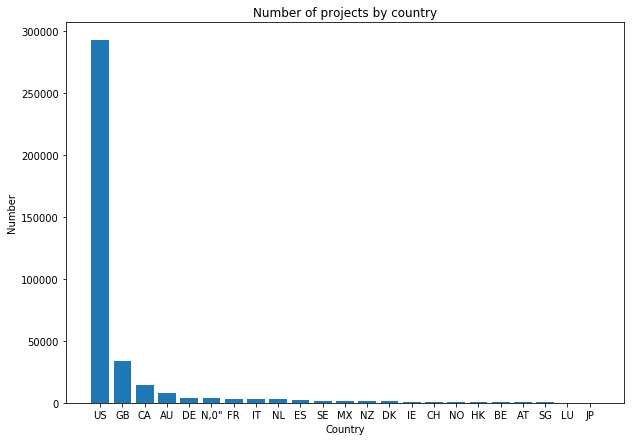

In [6]:
plt.figure(figsize=(10, 7))
plt.bar(np.arange(0, len(country_x)), country_y, tick_label = country_x,align = "center")
plt.title("Number of projects by country")
plt.xlabel("Country")
plt.ylabel("Number")

#### 円グラフで国ごとのプロジェクト件数の割合を表示

([<matplotlib.patches.Wedge at 0x11fdccc0>,
 [Text(-0.831476,0.720172,'US'),
  Text(0.451129,-1.00324,'GB'),
  Text(0.807532,-0.746922,'CA'),
  Text(0.932584,-0.583341,'AU'),
  Text(0.985988,-0.487676,'DE'),
  Text(1.01605,-0.421478,'N,0"'),
  Text(1.03801,-0.364067,'FR'),
  Text(1.05436,-0.313567,'IT'),
  Text(1.06811,-0.262966,'NL'),
  Text(1.07835,-0.217156,'ES'),
  Text(1.08501,-0.180959,'SE'),
  Text(1.08982,-0.149299,'MX'),
  Text(1.0934,-0.120326,'NZ'),
  Text(1.09571,-0.0970772,'DK'),
  Text(1.09712,-0.0795752,'IE'),
  Text(1.09806,-0.06526,'CH'),
  Text(1.09878,-0.0518726,'NO'),
  Text(1.09928,-0.0397818,'HK'),
  Text(1.09963,-0.0285164,'BE'),
  Text(1.09986,-0.0174396,'AT'),
  Text(1.09998,-0.00692683,'SG'),
  Text(1.1,-0.00129598,'LU'),
  Text(1.1,-0.000365107,'JP')],
 [Text(-0.453532,0.392821,'77.3%'),
  Text(0.24607,-0.54722,'8.9%'),
  Text(0.440472,-0.407412,'3.9%'),
  Text(0.508682,-0.318186,'2.1%'),
  Text(0.537811,-0.266005,'1.1%'),
  Text(0.554209,-0.229897,'1.0%'),
 

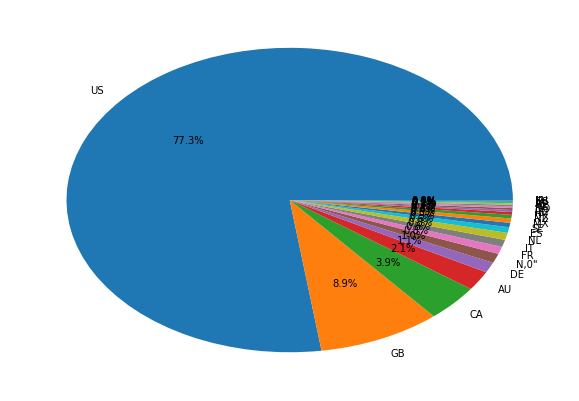

In [7]:
plt.figure(figsize=(10, 7))
plt.pie(country_y, autopct="%.1f%%", labels = country_x)

77%はアメリカで、ついでイギリス(GB)、カナダ(CA)となっている。  
上位3つで全体の9割を占めている。

#### 国ごとの「成功」、「失敗」の件数を可視化

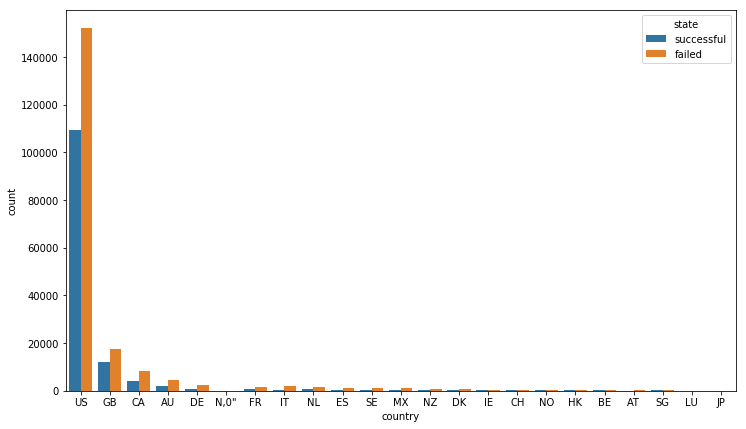

In [11]:
plt.figure(figsize=(12, 7))
sns.countplot(x = "country", hue = "state", hue_order = ["successful", "failed"], order = country_x, data = df_origin)

#### 国ごとの「成功」、「失敗」の割合を可視化

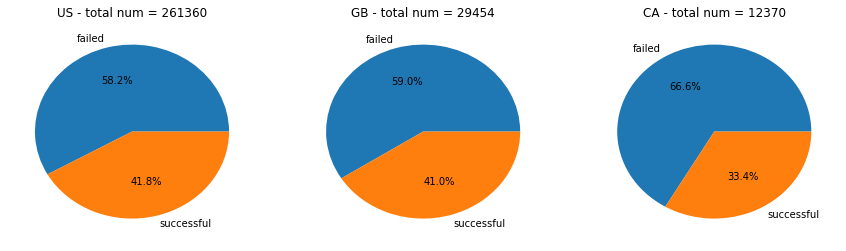

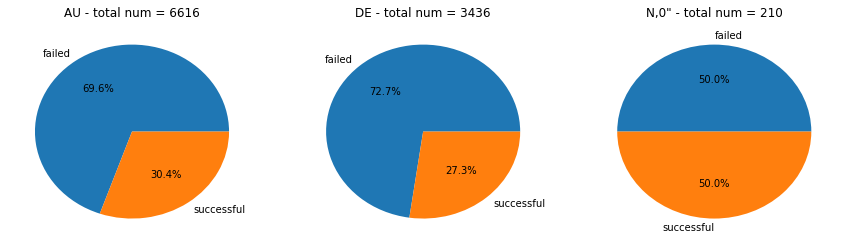

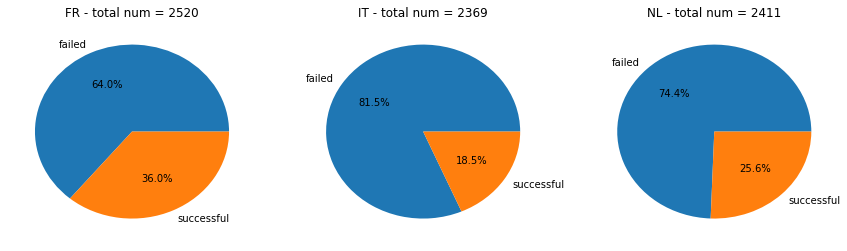

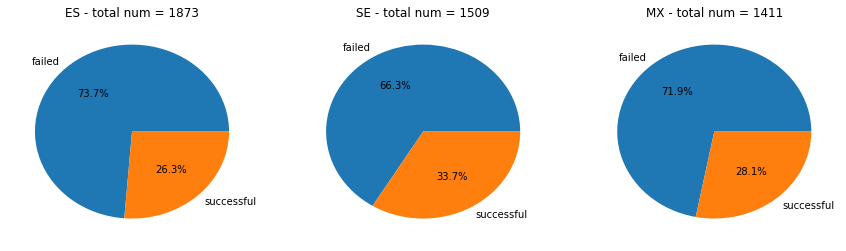

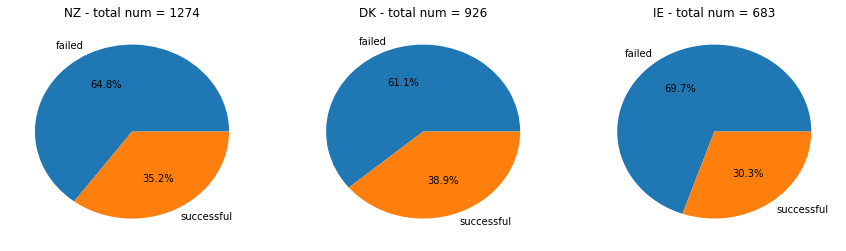

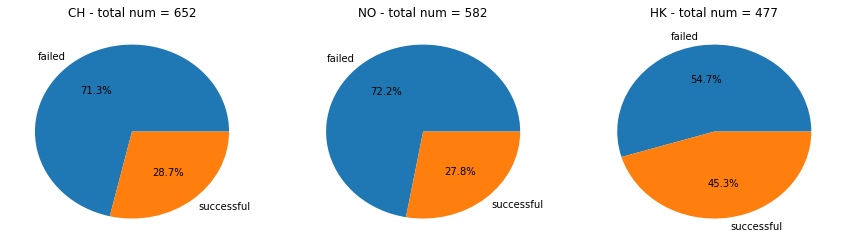

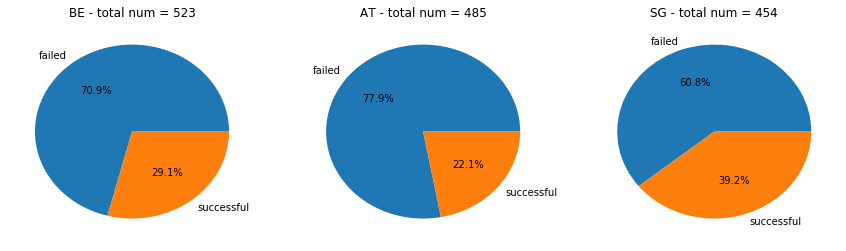

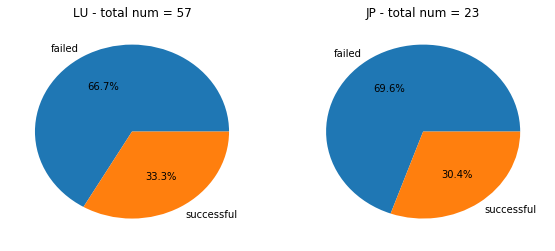

In [12]:
# 国ごとに「成功」、「失敗」の割合を可視化
# 円グラフで可視化
country_pie_graph_row = len(country_x) / 3
country_pie_graph_index = 0

plt.figure(figsize=(20, 4))

for country in country_x:
    # ある国のデータ
    df_country = df_origin[df_origin["country"] == country]
    # 「成功」と「失敗」のみのデータ
    df_country_success_or_failed = df_country[(df_country["state"] == "successful") | (df_country["state"] == "failed")]
    country_success_or_failed_x = df_country_success_or_failed["state"].value_counts().index
    country_success_or_failed_y = df_country_success_or_failed["state"].value_counts().values
    
    # 円グラフ描画
    plt.subplot(1, 4, country_pie_graph_index % 3 + 1)
    plt.title("{} - total num = {}".format(country, len(df_country_success_or_failed)))
    plt.pie(country_success_or_failed_y, autopct="%.1f%%", labels = country_success_or_failed_x)
    
    country_pie_graph_index = country_pie_graph_index + 1
    
    # 1行に3つずつグラフ描画
    if (country_pie_graph_index % 3) == 0:
        #plt.legend(loc='best')
        plt.show()
        plt.figure(figsize=(20, 4))
    # 最後
    elif country_pie_graph_index == len(country_x):
        #plt.legend(loc='best')
        plt.show()

### 結論  
英語圏の方が成功率が高い傾向がある。  
よって英語圏かそうでないかの説明変数の追加を検討する。

### Kickstarterの最近の成功/失敗の傾向を観察する

In [13]:
# プロジェクト締切日(deadline)で年別に成功/失敗を可視化する
df_success_or_failed = df_origin[(df_origin["state"] == "successful") | (df_origin["state"] == "failed")]
# TODO 
# SettingWithCopyWarningが出る
#df_success_or_failed["Year"] = pd.to_datetime(df_success_or_failed["deadline"], format = "%Y-%m-%d %H:%M:%S").dt.year
# SettingWithCopyWarningを回避するためだけのcopy。時間が出来たら原因を調べたい
df_success_or_failed = df_success_or_failed.copy()
df_success_or_failed["Year"] = pd.to_datetime(df_success_or_failed["deadline"], format = "%Y-%m-%d %H:%M:%S").dt.year

#### 年ごとのプロジェクト件数

Text(0,0.5,'Number')

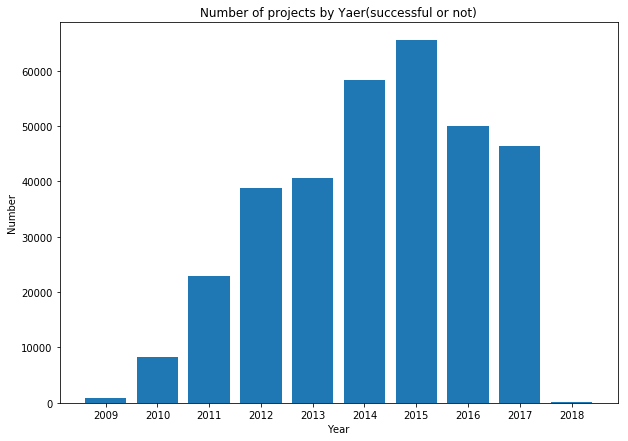

In [15]:
df_Year = pd.DataFrame({"Year":df_success_or_failed["Year"].value_counts().index, 
                   "Count":df_success_or_failed["Year"].value_counts().values})
df_Year = df_Year.sort_values(by = ["Year"], ascending = [True])

plt.figure(figsize=(10, 7))
plt.bar(np.arange(0, len(df_Year)), df_Year["Count"].values,
                                        tick_label = df_Year["Year"].values, align = "center")
plt.title("Number of projects by Yaer(successful or not)")
plt.xlabel("Year")
plt.ylabel("Number")

#### 年ごとのプロジェクト成功件数と失敗件数

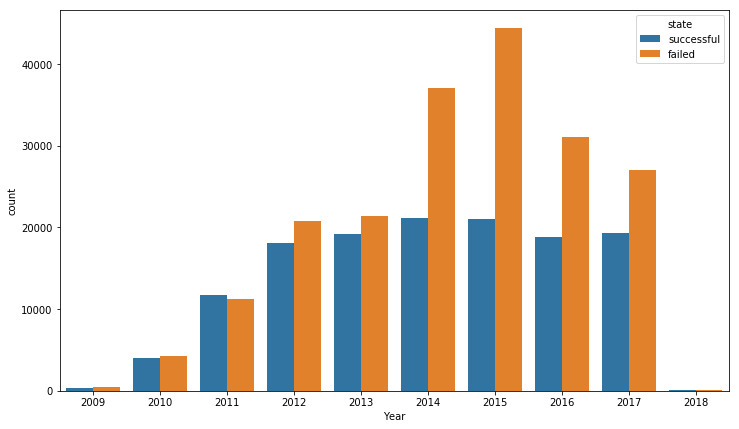

In [16]:
plt.figure(figsize=(12, 7))
sns.countplot(x = "Year", hue = "state", hue_order = ["successful", "failed"], order = df_Year["Year"].values, data = df_success_or_failed)

2013年までは約半数のプロジェクトが成功している。  
2014年、2015年には2013年までと比べて、総プロジェクト件数は伸びたが、成功したプロジェクトは  
それほど伸びていない。  
その傾向を見てか、2015年をピークにプロジェクト件数は減少傾向  
ブームに乗った準備不足のプロジェクトが乱立したことが原因なのか？

#### 資金調達率が30%未満の大失敗プロジェクトの割合の推移

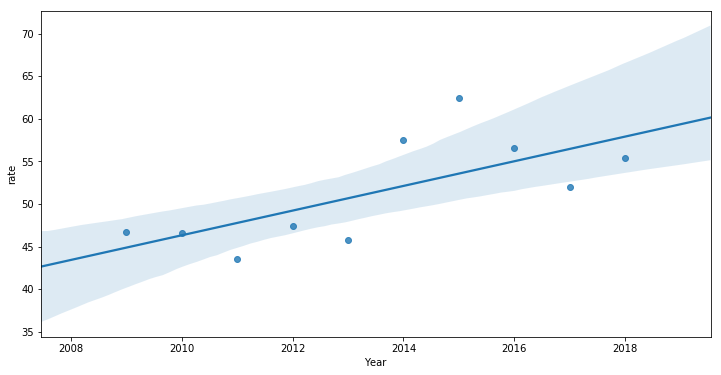

In [17]:
# 年ごとの資金調達率を可視化
# 調達率 = (usd_pledged_real / usd_goal_real) * 100
df_pledged_rate = pd.DataFrame({"Year":df_success_or_failed["Year"].values,
                                    "usd_pledged_real":df_success_or_failed["usd_pledged_real"].values,
                                    "usd_goal_real":df_success_or_failed["usd_goal_real"].values,
                                   "pledged_rate":(df_success_or_failed["usd_pledged_real"].values) / df_success_or_failed["usd_goal_real"].values * 100})

# 資金調達率が30%未満の大失敗プロジェクトの割合を年ごとに集計
df_big_failed = df_pledged_rate[df_pledged_rate["pledged_rate"] < 30]
df_big_failed_for_graph = pd.DataFrame({"Year":df_big_failed["Year"].value_counts().index,
                                           "rate":np.zeros(10)})
# 年ごとのデータを計算してセット
index = 0
for year in df_big_failed_for_graph["Year"].values:
    df_big_failed_for_graph.loc[index,"rate"] = len(df_big_failed[df_big_failed["Year"] == year]) / len(df_pledged_rate[df_pledged_rate["Year"] == year]) * 100
    index = index + 1

# Seabornで線形回帰プロット
plt.figure(figsize=(12, 6))
sns.regplot(df_big_failed_for_graph.Year, df_big_failed_for_graph.rate)

### 結論  
成功、失敗の割合の変化が大きい2014年以降、以前で分けて考えたほうがよいのかもしれない。  
資金調達率(目標額に対する調達額の割合)が低いプロジェクトも増加傾向。(2014年以降は目標の30%も集められないプロジェクトが50%を超えている)  
最近の傾向を知るためには2014年以降のデータで、学習、評価を行うほうがよいのかも。